# 2025.05.26

## TODO:
- [ ] Figure out coupling between conduit and atmosphere (what is conserved?)
    - [ ] Similarly, I am finding that the eruption actually behaves differently with the atmospheric coupling. Need to figure out how this works 
- [x] Simplify eruption model to have clean eruption
- [x] Inspect mesh, make sure that the number of cells is greater conduit.
- [x] For model v12 increase the fidelity (number of timesteps of the model)


In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import matplotlib.pyplot as plt 

plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

In [198]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 20
C0 = 320 # m/s at 5000m

## 1.0 Back to the basics! Simple eruption model

Let's calculate $p_0$, the pressure just to the left of the plug. 

$$
\begin{align}
M \ddot{s} &= A (p_0 + \Delta p(s(t))) - p_{atm}A - Mg - 2 \pi R \tau(s(t)) \\
p_0 &= p_{atm} + \frac{2 L \tau_p}{R} + \rho L g \\
p_0 &= 1e5 + \frac{2* 50 [m] * 1e6 [Pa]}{10 [m]} + 2.6e3 [kg/m^3] * 50[m] * 9.8[m/s^2] \\
p_0 &= 11.4e6 \\
\end{align}
$$

And then $P_L$ will need to also take into account gravity:

$$
\begin{align}
p_L &= p_0 + g L \rho \\
p_L &= 11.4e6 + 950 [m] * 9.8 [m/s^2] * 2.6e3 [kg/m^3] \\
p_l &= 36.6e6
\end{align}
$$

When I run the simulation with these parameters, there is minor settling but basically the quail code agrees this is a steady state solution. 

In [391]:
file_name = "short_plug_v11"

solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=ITERS,
    d_iterations=D_ITERS,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=10,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
    show_p0_line=True,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/basic_simulation_with_slip.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)

HTML(ani.to_html5_video())

We have [previously shown](https://paxtonsc.github.io/files/geophysics/volcano_project/weekly_notes/2025.03.07.experiments.html), that the system is unstable when 

$$
D_c < \frac{L_m L_p (\tau_p - \tau_r)}{RK}
$$

In this case:

$$
\begin{align}
D_c &< \frac{950 [m] * 50 [m] * 1e6 [Pa]}{10 [m] * 1e9 [Pa]} \\
D_c &< 4.7 \\
\end{align}
$$


So lets drop the $D_c$ value down to 3. As we can see below, that (along with a slight instability in initial conditions) is sufficient to precipitate an eruption.  

Based on the numerical steady state above, we find that the **steady state conditions** are actually:

$P_L = 3.57e7$
$P_0 = 11.33e6$

When I plug those values in, no eruption! In fact, I need to increase the values marginally **to tip the eruption off**:

$P_L = 3.7e7$
$P_0 = 11.5e6$

Does the trick. 

In [392]:
file_name = "short_plug_v12"
iters = 50
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(solver_func, iterations=iters, d_iterations=D_ITERS, viscosity_index=2, wall_friction_index=1, max_velocity=5, max_slip=60, max_tau=1.5, max_pressure=50, max_speed_of_sound=1000, max_water=1, max_density=5e3, max_fragmentation=5000, max_crystal=100, max_viscosity=0.1)

ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4', writer='ffmpeg', fps=10, bitrate=1800)
HTML(ani.to_html5_video())

In [314]:
viscosity_index = 2
slip_time_series = []
times = []
solver_func = get_local_solver_from_index_func(folder_name, file_name)

for i in range(0, iters):
    solver = solver_func(i)
    arhoA = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityA")]
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWv = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWv")]
    arhoC = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityC")]
    arhoM = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityM")]
    arhoF = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityFm")]

	# Get the value of the new state variable.
    rho_mix = arhoA + arhoWv + arhoM + arhoF
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
		
    # Get the value of the new state variable.
    slip_time_series.append((solver.state_coeffs[:,:,solver.physics.get_state_index("rhoSlip")]/rho_mix).ravel()[-1])
    times.append(solver.time)

In [402]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants (you can modify these values as needed)
K = 1e9      # Some constant (friction/damping)
L_melt = 950 # Melt length
tau_p = 1e6  # principle shear stress
tau_r = 0  # residual shear stress
R = 10      # Radius [m]
L_plug = 50 # Plug length
g = 9.81 # [m/s^2]

rho = 2.6e3  # Density

M_plug = R**2 * np.pi * L_plug * rho    # Mass
C = 600 # [m/s] Speed of sound in magma 

# Account for adding mass effect.
M_eff = M_plug #* (1 + L_melt / (L_plug*2))
D_c = 3

# visocity
mu = 5e4

A = np.pi * R**2  # Cross-sectional area
p0 =11.5e6  # Pressure at the top of the conduit
p_atm = 1e5  # Atmospheric pressure

def tau(s):
    #return tau_r - (tau_r - tau_p) * np.exp(s / D_c)

    if s < D_c:
        return tau_p - (tau_p - tau_r) * s / D_c
    else:
        return tau_r

# Define the system of differential equations
def system(state, t):
    s1, s2 = state  # s1 is position, s2 is velocity
    
    # ds1/dt = s2
    ds1_dt = s2
    
    # ds2/dt = (-A*K*s2)/(M*L_melt) + ((tau_p - tau_s)*2*pi*R*(L_plug - s1)*s1)/M
    ds2_dt =  (-A * K * s1) / (M_eff * L_melt) + \
            (A * (p0 - p_atm) / M_eff) + \
             - (tau(s1) * 2 * np.pi * R * L_plug) / M_eff - \
             4 * np.pi * mu * L_melt * s2 / M_eff \
            - g
    
    return [ds1_dt, ds2_dt]

# Initial conditions
s1_0 = 0.0  # Initial position
s2_0 = 0.0  # Initial velocity
initial_state = [s1_0, s2_0]

# Time points
t = np.linspace(0, 20, 500)  # Time from 0 to 10 with 1000 points

# Solve the differential equations
solution = odeint(system, initial_state, t)

# Extract solutions
s1 = solution[:, 0]  # Position
s2 = solution[:, 1]  # Velocity

<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_20974/1185562166.py:18: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("$\dot{s}$ [m/s]")


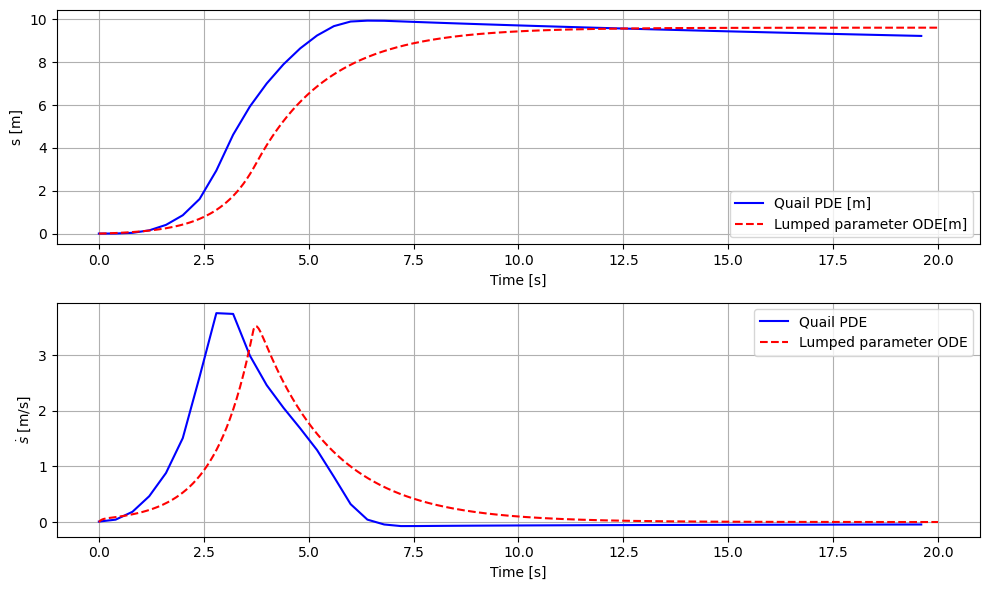

In [403]:
slip_dot = np.gradient(slip_time_series, times)

# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(times, slip_time_series, 'b-', label='Quail PDE [m]')
plt.plot(t, s1, 'r--', label='Lumped parameter ODE[m]')
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, slip_dot, 'b-', label='Quail PDE')
plt.plot(t, s2, 'r--', label='Lumped parameter ODE')
plt.xlabel("Time [s]")
plt.ylabel("$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/lumped_parameter_model.png")
plt.tight_layout()
plt.show()

## 2.0 Adding atmosphere 

First, let's review our mesh. I have modified it to have a 10m radius and very small triangles in and around the the conduit. Here are the results. 


/Users/paxton/git/quail_volcano/src

Points: (6316, 3)
Cells: dict_keys(['line', 'triangle'])
Cell Sets: {}


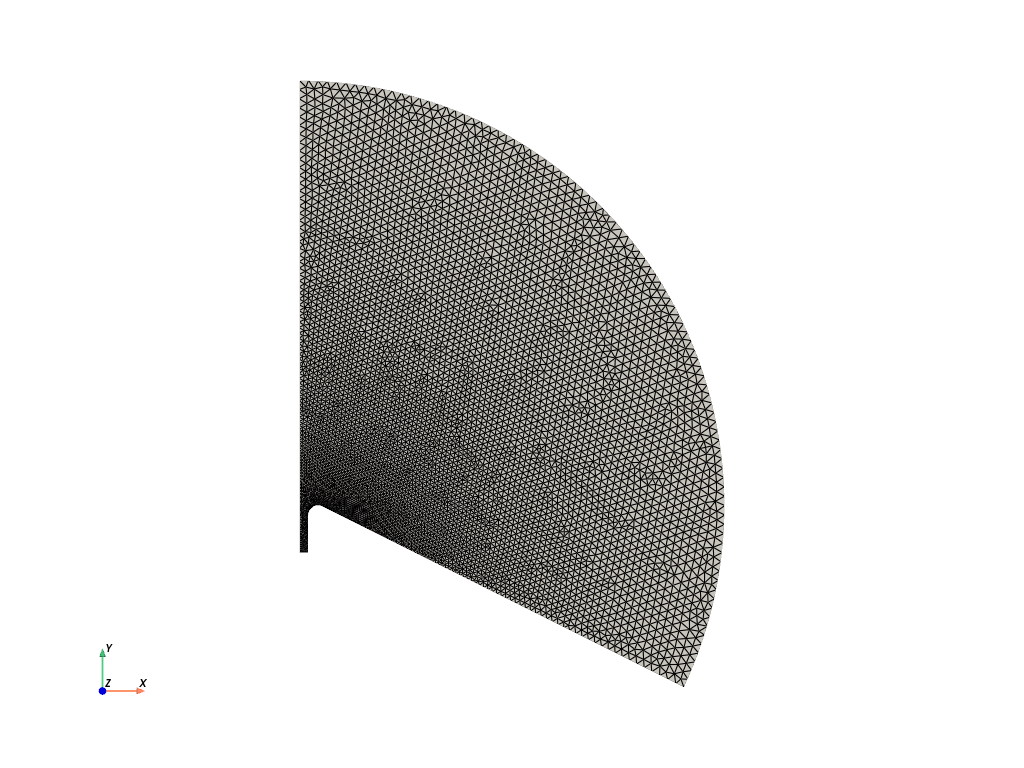

In [389]:
import meshio
import pyvista as pv
import os

print(os.getcwd())

mesh = meshio.read(f"{BASE_PATH}/quail_volcano/scenarios/meshes/tungurahuaA1.msh")

# Clear cell sets to avoid the error
mesh.cell_sets.clear()

# Print mesh details
print("Points:", mesh.points.shape)
print("Cells:", mesh.cells_dict.keys())
#for cell_type, cell_data in mesh.cells_dict.items():
    #print(f"Cell type {cell_type}: {cell_data.shape}")
print("Cell Sets:", mesh.cell_sets)
#print("Cell Data:", mesh.cell_data)

pv.set_jupyter_backend('static')

# Convert to pyvista mesh
pv_mesh = pv.from_meshio(mesh)

# Create a plotter and visualize
plotter = pv.Plotter()

plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.set_scale(xscale=1.0, yscale=1.0, zscale=1.0)
plotter.camera.roll += 80



plotter.view_xy()  # For 2D meshes; use view_isometric() for 3D
plotter.show_axes()
plotter.show()

In [ ]:
file_name = "short_plug_v14"
iters = 68
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(solver_func, iterations=iters, d_iterations=D_ITERS, viscosity_index=2, wall_friction_index=1, max_velocity=5, max_slip=60, max_tau=1.5, max_pressure=50, max_speed_of_sound=1000, max_water=1, max_density=5e3, max_fragmentation=5000, max_crystal=100, max_viscosity=0.1)

ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4', writer='ffmpeg', fps=10, bitrate=1800)
HTML(ani.to_html5_video())

In [404]:
viscosity_index = 2
atm_slip_time_series = []
atm_times = []
file_name = "short_plug_v13"
iters = 47
solver_func = get_local_solver_from_index_func(folder_name, file_name)

for i in range(0, iters):
    solver = solver_func(i)
    arhoA = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityA")]
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWv = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWv")]
    arhoC = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityC")]
    arhoM = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityM")]
    arhoF = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityFm")]

	# Get the value of the new state variable.
    rho_mix = arhoA + arhoWv + arhoM + arhoF
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
		
    # Get the value of the new state variable.
    atm_slip_time_series.append((solver.state_coeffs[:,:,solver.physics.get_state_index("rhoSlip")]/rho_mix).ravel()[-1])
    atm_times.append(solver.time)

<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_20974/3827135110.py:20: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("$\dot{s}$ [m/s]")


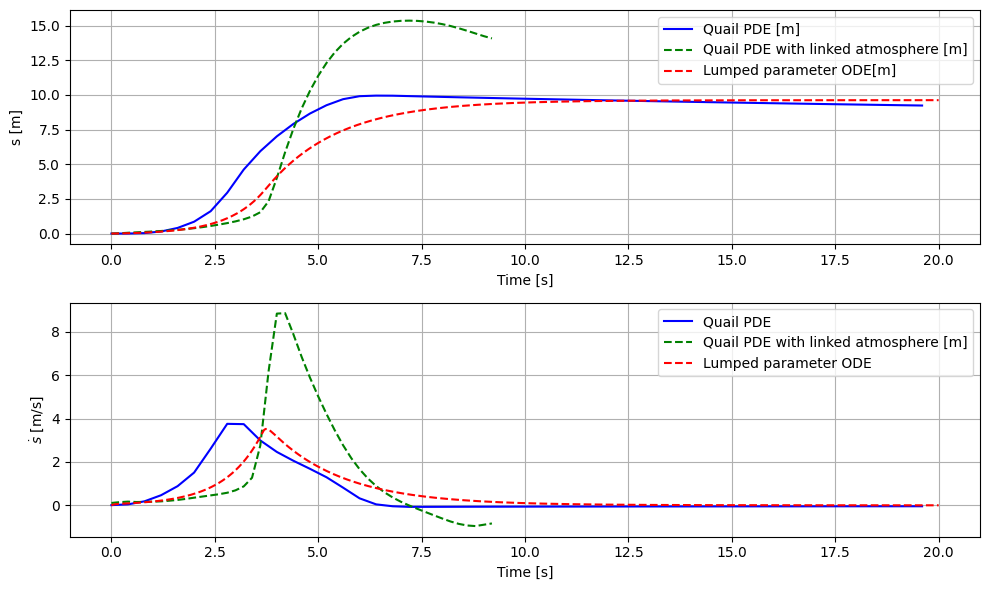

In [405]:
atm_slip_dot = np.gradient(atm_slip_time_series, atm_times)

# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(times, slip_time_series, 'b-', label='Quail PDE [m]')
plt.plot(atm_times, atm_slip_time_series, 'g--', label='Quail PDE with linked atmosphere [m]')
plt.plot(t, s1, 'r--', label='Lumped parameter ODE[m]')
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, slip_dot, 'b-', label='Quail PDE')
plt.plot(atm_times, atm_slip_dot, 'g--', label='Quail PDE with linked atmosphere [m]')
plt.plot(t, s2, 'r--', label='Lumped parameter ODE')
plt.xlabel("Time [s]")
plt.ylabel("$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/lumped_parameter_model.png")
plt.tight_layout()
plt.show()

In [407]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 140

# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("simple_conduit", "test_infrasound_v0_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e3, 1e3)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")
x1, p1_0= mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, p1= mdtools.downsample(solver2D_atm1(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x1, p1 - p1_0, clims)
    plt.title(f"Order 1: Pressure Field at t= {round(solver2D_atm1(frame).time)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 2),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/quail_small_eruption.mp4', writer='ffmpeg', fps=10, bitrate=1800)
plt.close(fig)  # Clean up

In [384]:
import matplotlib.tri as tri
from helper_code.infrasound import *
solver_2D = solver2D_atm1(0)

triangulation = tri.Triangulation(solver_2D.mesh.node_coords[...,0],
                  solver_2D.mesh.node_coords[...,1], 
                  triangles=solver_2D.mesh.elem_to_node_IDs)
trifinder = triangulation.get_trifinder()

p_100 = infrasound.get_p_series(100, 0, solver2D_atm1, trifinder, iterations=235)
p_250 = infrasound.get_p_series(250, 0, solver2D_atm1, trifinder, iterations=235)
p_400 = infrasound.get_p_series(400, 0, solver2D_atm1, trifinder, iterations=235)

Element ID for point (100, 0): 838


/Users/paxton/git/volcano_sims/notebooks/helper_code/infrasound.py:86: UserWarning: Warning: converting a masked element to nan.
  U_target = np.array([tri.CubicTriInterpolator(
/Users/paxton/git/volcano_sims/notebooks/helper_code/infrasound.py:86: UserWarning: In TriCubicInterpolator initialization, PCG sparse solver did not converge after 1000 iterations. `geom` approximation is used instead of `min_E`
  U_target = np.array([tri.CubicTriInterpolator(


Element ID for point (250, 0): 433
Element ID for point (400, 0): 3049


Max pressure value at r=2000m is 19.48956927532563


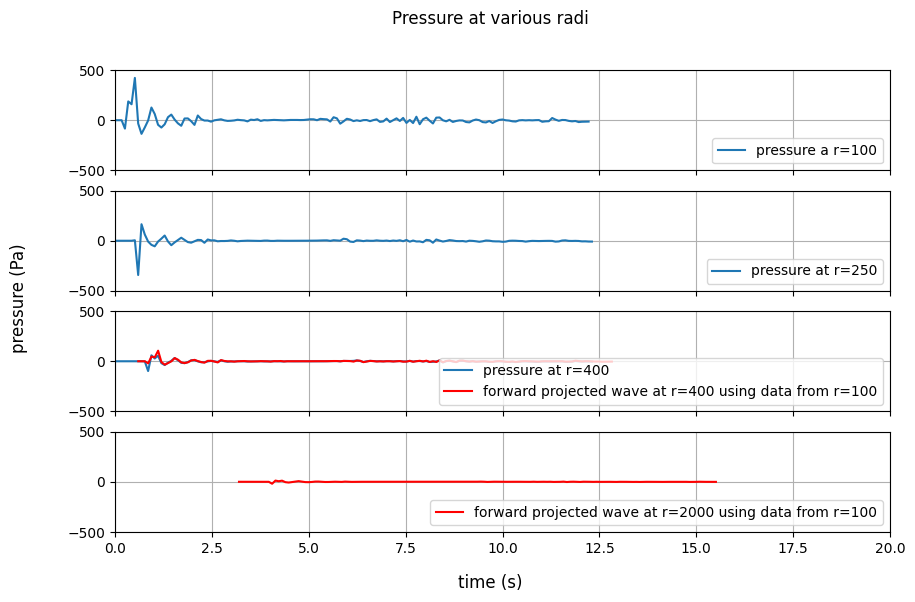

In [388]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 6), sharex=True)
t = np.linspace(0, 20, len(p_100))
C0 = 500

axes[0].plot(t, p_100, label="pressure a r=100")
axes[1].plot(t, p_250, label="pressure at r=250")
axes[2].plot(t, p_400, label="pressure at r=400")


p_400_sim = np.asarray(p_100) * 100/400
t_adjusted_400 = t + 300/C0

p_2000_sim = np.asarray(p_400) * 400/2000
t_adjusted_2000 = t + 1600/C0


axes[2].plot(t_adjusted_400, p_400_sim, label="forward projected wave at r=400 using data from r=100", c='r')
axes[3].plot(t_adjusted_2000, p_2000_sim, label="forward projected wave at r=2000 using data from r=100", c='r')

for i, ax in enumerate(axes):
    ax.legend(loc='lower right')
    ax.grid(True)
    ax.set_ylim(-500, 500)  
    ax.set_xlim(0, 20)

fig.suptitle("Pressure at various radi")
fig.supylabel("pressure (Pa)")
fig.supxlabel("time (s)")

print(f"Max pressure value at r=2000m is {max(np.abs(p_2000_sim))}")

## Compare to monopole source simulation

In [398]:
import matplotlib

file_name = "short_plug_v12"
iters = 50
solver_func = get_local_solver_from_index_func(folder_name, file_name)

u_vec = []
t_vec = []
R = 10 # m

for i in range(0, iters, 1):
    solver = solver_func(i)
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
    rho = np.sum(solver.state_coeffs[:, :, solver.physics.get_mass_slice()],axis=2,keepdims=True)

    # Define velocity as momentum divided by density. "velocity" when computed as an additional state variable appears to be an absolute value. 
    u = momentum.ravel() / rho.ravel()

    # Take only the exit velocity
    u_vec.append(np.maximum(u[-1], 0))
    t_vec.append(solver.time)

a_vec = np.gradient(np.array(u_vec), np.array(t_vec))
Q_dot_vec = np.pi * R**2 * a_vec # m^3/s^2

N = 100
pressure_array = np.zeros((len(t_vec), N, N))
x_low, x_upper = -500, 3000
y_low, y_upper = -1000, 2500

X = np.linspace(x_low, x_upper, N)
Y = np.linspace(y_low, y_upper, N)

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(pressure_array[0], extent=[x_low, x_upper, y_low, y_upper], 
               aspect='auto', cmap=matplotlib.cm.PiYG, origin='lower', vmin=-10, vmax=10)
plt.colorbar(im, label='Pressure (Pa)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Pressure Distribution Over Time')

# Initialization function for animation
def init():
    im.set_array(np.zeros((N, N)))
    return [im]

# Animation update function
def update(t):
    t_idx = np.argmin(np.abs(np.array(t_vec) - t))  # Find the closest index in t_vec
    for i in range(N):
        for j in range(N):
            x = X[i]
            y = Y[j]

            if infrasound.point_in_volcano(x, y):
                pressure_array[int(t_idx), j, i] = 0  # Set pressure to 0 inside volcano
            else:
                pressure_array[int(t_idx), j, i] = infrasound.relative_pressure(t, x, y, t_vec, Q_dot_vec)

    im.set_array(pressure_array[int(t_idx)])
    ax.set_title(f'Pressure Distribution at t={t_idx:.2f} s')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, init_func=init, frames=np.asarray(t_vec), 
                    interval=200, blit=True)

ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/monopole_source.mp4', writer='ffmpeg', fps=10, bitrate=1800)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

Max pressure at r=1000m is 3.106895637470747 Pa


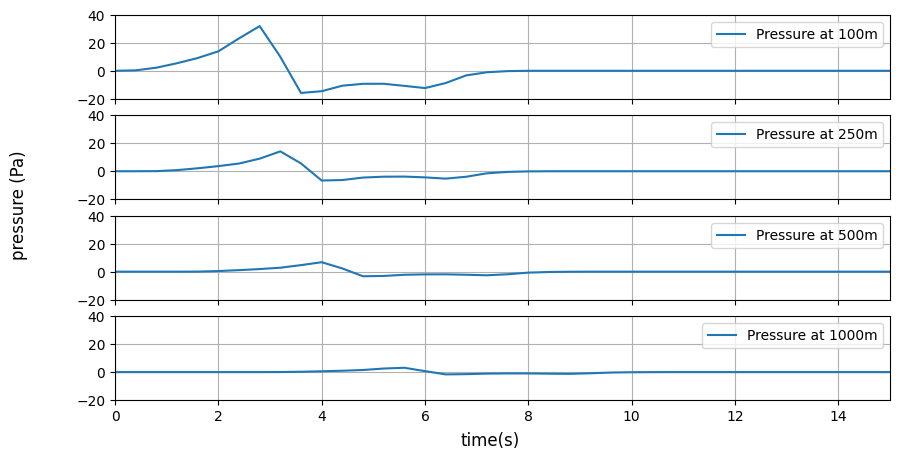

In [397]:
y_idx = np.argmin(np.abs(Y))

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 5), sharex=True)

axes[3].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 1000))], label="Pressure at 1000m")
axes[2].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 500))], label="Pressure at 500m")
axes[1].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 250))], label="Pressure at 250m")
axes[0].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 100))], label="Pressure at 100m")

for i, ax in enumerate(axes):
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_ylim(-20, 40)  
    ax.set_xlim(0, 15)

fig.supxlabel("time(s)")
fig.supylabel("pressure (Pa)")
plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/monopole_pressure_vs_time.png")

print(f"Max pressure at r=1000m is {max(np.abs(pressure_array[:, y_idx, np.argmin(np.abs(X - 1000))]))} Pa")